### Start by loading in the packages we need

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm.notebook import tqdm 

### Then we will make sure we have the data downloaded. At the same time we will transform the data and make sure the data is mormalized

In [8]:
# Transform the images to tensor and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Subset of samples from the training set cause I dont wanna train the whole thing cause it will take some time
subset_size = 10000 
indices = np.random.choice(len(trainset), size=subset_size, replace=False)
train_subset = Subset(trainset, indices)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


### Then we want to figure out the input and output sizes of the network. We could manually do this, but this makes our whole network more dynamic. This code would actually work for any images as long as all the images are the same size!

In [9]:
images, labels = next(iter(trainloader))
image_size = images[0].size()  # Get the size of a single image
flattened_size = torch.tensor(image_size).prod().item()  # Compute the flattened size

print(f"Image batch size: {images.size()}")
print(f"Single image size: {image_size}")
print(f"Flatten size: {flattened_size}")

num_classes = len(torch.unique(labels))
print(f"Number of unique classes: {num_classes}")

Image batch size: torch.Size([64, 1, 28, 28])
Single image size: torch.Size([1, 28, 28])
Flatten size: 784
Number of unique classes: 9


### A very simple neural network setup 

In [10]:
class SimpleNN(nn.Module):
    def __init__(self,input_size,num_classes):
        super(SimpleNN, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 128)  #
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)  # 10 output classes

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


# Initialize the network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(flattened_size,num_classes).to(device)

### set up the loss and optimizer. Both of these picks are kind of the standard when it comes to multiple neural networks 

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss() # multiclass closs function
optimizer = optim.Adam(model.parameters(), lr=0.001) # 

### Then we start training our network 

In [12]:
# Training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        
        # put things onto the device we are using 
        images = images.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # cal how the model is performing
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader)}, Accuracy: {correct/total*100}%")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [14,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [21,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [23,0,0] Assertion `t >= 0 && t < n

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Now we can view how well the network did

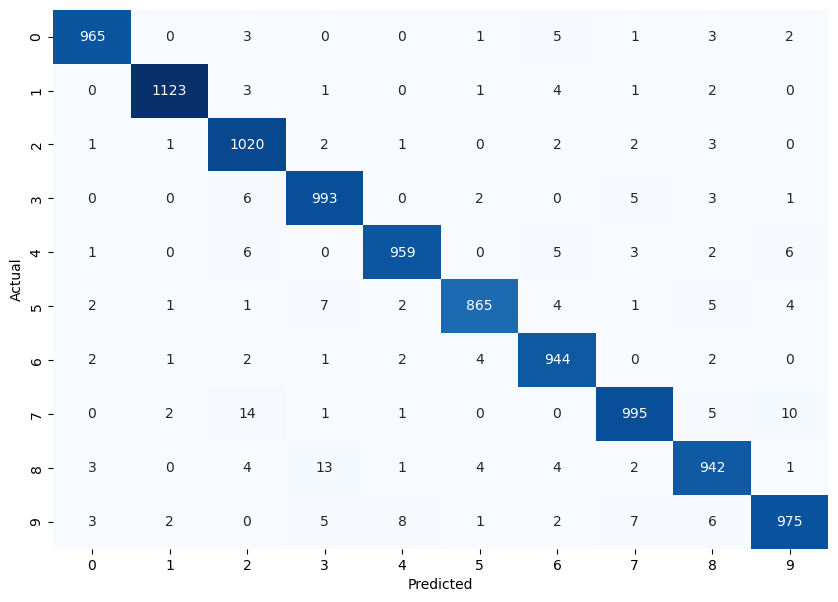

In [ ]:
# Testing the model
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())  # Move to CPU for processing
        all_predictions.extend(predicted.cpu().numpy())  # Move to CPU for processing

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
df_cm = pd.DataFrame(cm, index=[i for i in range(10)], columns=[i for i in range(10)])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


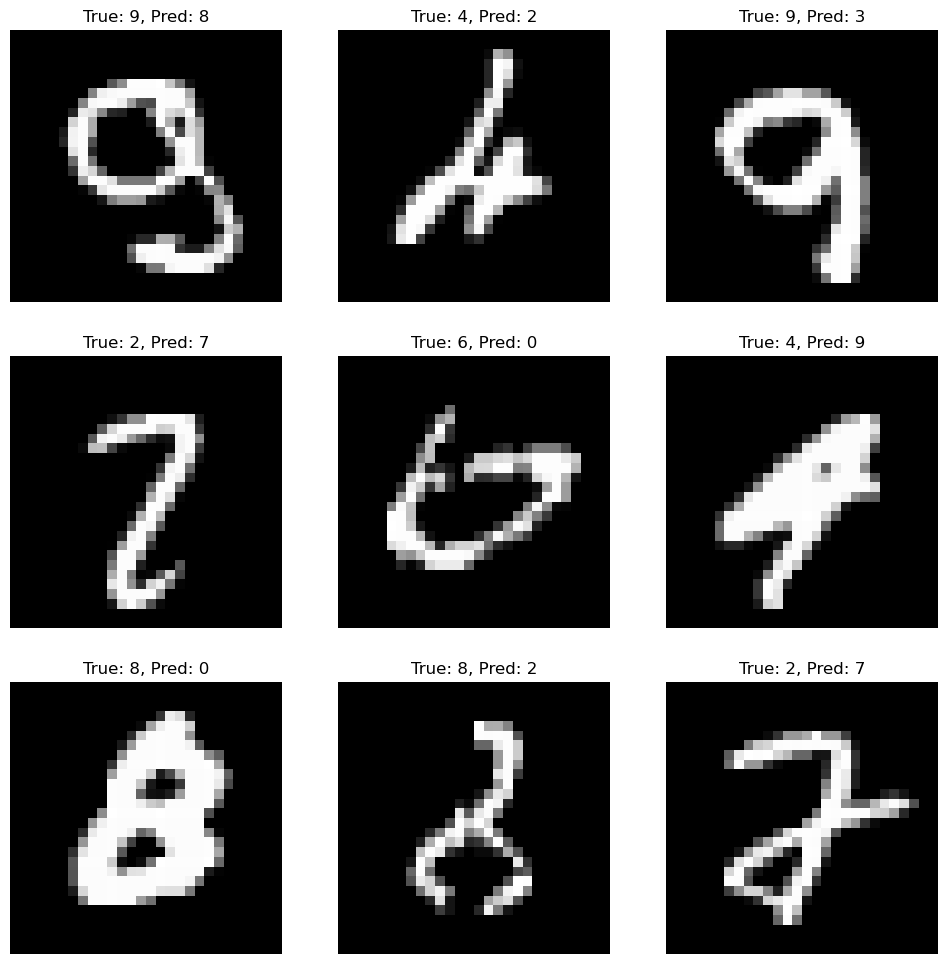

In [ ]:
incorrect_indices = np.where(np.array(all_labels) != np.array(all_predictions))[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(incorrect_indices[:9]):  # Display the first 9 incorrect ones
    plt.subplot(3, 3, i+1)
    plt.imshow(testset.data[idx].numpy(), cmap='gray')
    plt.title(f"True: {all_labels[idx]}, Pred: {all_predictions[idx]}")
    plt.axis('off')
plt.show()
